# HMM Tutorial

Welcome to the HMM tutorial! Here we'll go over the basic functionality of Homomorph. It's a small package, so the explanation of the HMM class will be brief and will largely focus on formatting the inputs correctly. (HMMs are relatively parameter-rich, so the syntax for properly specifying all the components can be a little verbose!) The first portion of this tutorial is a brief introduction to HMM theory and applications, so feel free to skip to the next section if you're already familiar with HMMs.

## 1 HMM Theory and Applications

### 1.1 What are HMMs and what are they good for?

Sequential data are all around us, appearing in fields as diverse as meteorology (temperature), economics (stock market indices), and bioinformatics (DNA), to name a few. What unites these disparate phenomena is a common underlying structure: each observation is sampled at regularly spaced intervals along some dimension, usually time. In fact, this dimension is so often time that the study of this kind of data is called time series analysis. Its techniques are so numerous that they fill entire textbooks, but one particularly powerful tool is the hidden Markov model (HMM). Unlike most statistical models, which typically assume a single underlying distribution, HMMs are well-adapted to complex data generated by multiple, non-overlapping processes. To return to the previous examples, sometimes there are heat waves, bull and bear markets, and genes interspersed in vast oceans of non-coding DNA. In all these cases, the data appear to toggle between different unobserved states that yield measured observations with distinct distributions. These "hidden" states introduce considerable complexity in the modeling process; however, HMMs provide a framework for incorporating them in a fully probabilistic manner. This in turn allows us to calculate the probability of a sequence of observations (a calculation which forms the basis of many statistical tests) as well as to to infer the underlying states.

### 1.2 A formal definition

With the informal introduction out of the way, let's now give some definitions. The notation as well as some of the subsequent examples are adapted from the book *[Biological Sequence Analysis](https://doi.org/10.1017/CBO9780511790492)*. It's an excellent resource on HMMs, so please refer to it for a more detailed presentation on theory and applications.

At the core of an HMM is a Markov chain. Markov chains model the evolution of system over a set of *states* (often in discrete time steps) with the constraint that the probability of moving to next state only depends on the current state. This Markov property dramatically simplifies calculations and allows the efficient algorithms described later. It is,  however, in many cases a gross simplification. The temperature tomorrow depends on more than the temperature today, for example. Despite this, HMMs are still sufficiently flexible to model a variety of phenomena.

The sequence of states generated by the Markov chain is a *path*, $X$, and the $t$th state in this path is called $X_t$. The *transition probability* from state $i$ to $j$ is then defined as $a_{ij} = P(X_{t+1} = j | X_t = i)$. These values are typically arranged in a matrix for ease of display and calculation.

The states are often unknown or "hidden," and we instead observe a value associated with each state called an *emission*. Together these emissions form a separate, parallel sequence, $Y$. An emission depends only on the current state, which is expressed mathematically as

$$
P(Y_t = y_t | X = x) = P(Y_t = y_t | X_t = x_t).
$$

In effect, each state has an associated emission distribution, so at each time step we use the distribution of the current state to sample an emission. These emissions are typically all of the same type or unit, so we can't immediately distinguish the state from the emissions alone.

As mentioned previously, there are two main applications of HMMs. The first of these is calculating the probability of a sequence of emissions. This is actually deceptively hard. If we knew the states, then we could easily look up the probabilities for each emission and transition and multiply all these values together. However, because the states are unknown, we have to account for all possible paths through the model. Mathematically this is represented as $P(Y=y) = \sum_x P(X=x, Y=y)$. If there are are $S$ states and $X$ has length $n$, then there are $S^n$ possible state sequences. This quantity grows exponentially, so a brute-force approach of listing all the possible state sequences is intractable except for trivial examples. Fortunately, the Markov property of HMMs permits a clever way of arranging these calculations that dramatically reduces the computational cost. I won't get into the details here, but it's called the *forward algorithm* and uses a technique called dynamic programming if you're interested in learning more.

The second application of HMMs is answering the question, "What sequence of states most likely produced these emissions?" This has two answers depending on exactly how "most likely" is defined. In the first interpretation, we find the most likely sequence of states with the *Viterbi algorithm* whereas in the second we find the distribution of states at each time step given the emissions with the *forward-backward algorithm*. The difference is subtle, but it essentially amounts to the difference between taking a global and local view of the sequence of emissions. Described mathematically, the Viterbi algorithm yields $x^* = \text{argmax}_x P(X=x|Y=y)$ and the forward-backward algorithm yields $P(X_t = x_t|Y=y)$. The practical consequences of this distinction are discussed later. Additionally, as with the forward algorithm, the hidden states introduce considerable complexity to the calculations, so both algorithms employ efficient recursive solutions. I'll again leave the details to other sources, however.

## 2 The HMM Class

Now that we're familiar with the what and why of HMMs, let's make some models and do calculations with them! We'll first need to import Homomorph and some helper packages.

In [1]:
from functools import reduce

import homomorph
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

HMMs are relatively parameter-rich since they have transition, emission, and start distributions. Transition and start distributions are specified with dictionaries, whereas the emission distributions can use dictionaries or SciPy random variables. I'll demonstrate both beginning with the classic "occasionally dishonest casino" example in the dictionary style.

### 2.1 The occasionally dishonest casino

Imagine there's a casino which is a little greedier than average. One of the casino's most popular games is a simple coin flip. Heads the patron wins, tails the house. Obviously this game is entirely too fair, so the management decides to tilt the odds in the casino's favor by having the dealers occasionally swap the coin for a double-tailed one. The casino doesn't want to get caught, so they only do the swap rarely and try to switch back before the patron gets suspicious. We can even imagine the randomness is a result of the dealer only making a switch when the patron is distracted.

#### 2.1.1  Dictionary style instantiation

Let's make this scenario more precise by assigning labels and numbers. The two states are either "fair" or "2-tailed," and the two possible emissions are either "heads" or "tails." Describing the transition, emission, and start distributions in words will belabor it, so I'll instead demonstrate the syntax by example and then discuss the key points.

In [2]:
coin = homomorph.HMM(t_dists={'fair': {'fair': 0.98, '2-tailed': 0.02}, '2-tailed': {'fair': 0.15, '2-tailed': 0.85}},
                     e_dists={'fair': {'heads': 0.5, 'tails': 0.5}, '2-tailed': {'tails': 1}},
                     start_dist={'fair': 0.99, '2-tailed': 0.01},
                     name='dishonest_coin')
coin

HMM(states={'fair', '2-tailed'},
    stop_states=[],
    name='dishonest_coin')

The transition, emission, and start distributions are specified by the `t_dists`, `e_dists`, and `start_dist` arguments, respectively, which I'll discuss in greater detail below.

`t_dists` is always a nested dictionary where the outer key is the initial state and the inner key is the target state. In this case, there is a 98% chance a fair coin stays fair on the next flip. The `HMM` class checks this object is well-defined in two respects. First, the values in each inner dictionary must sum to one. Second, every target state in the inner dictionaries must have an associated outer dictionary. In other words, every target state must have a defined transition distribution.

In the dictionary style, `e_dists` is also given by a nested dictionary with the same structure except the inner dictionaries are keyed by emission labels. As with the transition distributions, the `HMM` class checks that the values in each inner dictionary sum to one. It also checks every state has an associated emission distribution.

At this point, `start_dist` is simple! It's just a dictionary mapping state labels to probabilities. States with zero probability do not need a key. (This is also true of inner dictionaries in `t_dists` and `e_dists`, even though it's not apparent for the former in this example.)

#### 2.1.2 Simulation

Now that we have specified our model, let's generate some data.

In [3]:
step_num = 150

steps = coin.simulate(step_num, random_state=7)  # Fix random seed for reproducibility
steps[:5]

[('fair', 'tails'),
 ('fair', 'heads'),
 ('fair', 'tails'),
 ('2-tailed', 'tails'),
 ('2-tailed', 'tails')]

The simulation is returned as a single list of (state, emission) pairs. Let's extract the states and emissions separately, so we can visualize them fully with a plot.

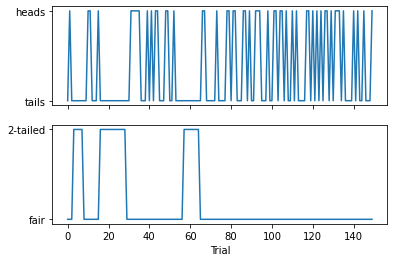

In [4]:
states = [step[0] for step in steps]
emits = [step[1] for step in steps]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states)
axs[1].set_xlabel('Trial');

#### 2.1.3 The forward algorithm

Given the transition probabilities, unsurprisingly the dealer uses the fair coin most of the time. However, there are some conspicuous runs of tails that correspond to the double-tailed coin. Recall the two major questions of HMMs are "How likely is this sequence of emissions?" and "What sequence of states most likely produced these emissions?" Let's tackle the first one now, which is given by the output of the forward algorithm. The return value has two parts. The first is a dictionary lists of the forward variables at each time step keyed by their state label. The second is a list of scaling factors that I'll discuss shortly.

In [5]:
fs, ss = coin.forward(emits)
print(fs['fair'][:5])
print(fs['2-tailed'][:5])

[0.9801980198019802, 1.0, 0.9607843137254901, 0.9001490312965723, 0.8134399956758509]
[0.019801980198019802, 0.0, 0.0392156862745098, 0.09985096870342774, 0.18656000432414901]


The forward variables at each step are scaled, so their sum is one. Thus, at each step we divide by the actual sum, which is given by the second element of the return value, called `ss` here. To undo this scaling, we have to multiply the forward variable at step $t$ by all the scaling factors up to and including step $t$. Since we're interested in the probability of the entire sequence, we'll multiply the values of the final forward variables by the product of all scaling factors. Don't worry if this doesn't make sense. Just follow the steps below to transform the forward variables into properly scaled probabilities.

Since the forward variable gives the probability of the emissions given the final hidden state, we need to add the values of the forward variables for both the fair and double-tailed states. In this particular case, the final emission was a heads, so the forward variable is zero for the double-tailed state, and it doesn't actually contribute to the total probability.

In [6]:
s = reduce(lambda x, y: x*y, ss)
pA_fair = fs['fair'][-1]*s
pA_2tailed = fs['2-tailed'][-1]*s
pA = pA_fair + pA_2tailed
print('Probability of emissions and ending with fair coin:', pA_fair)
print('Probability of emissions and ending with double-tailed coin:', pA_2tailed)
print('Probability of emissions:', pA)

Probability of emissions and ending with fair coin: 6.280882009514273e-43
Probability of emissions and ending with double-tailed coin: 0.0
Probability of emissions: 6.280882009514273e-43


The probability of this sequence of emissions is staggeringly small. Take a look at this [xkcd comic](https://xkcd.com/2379/) for some entertaining situations involving highly unlikely events, and you can see just how unlikely this particular sequence of heads and tails was. That doesn't immediately mean anything is suspicious though. Even if a fair coin were flipped the entire time, the resulting sequence would still have a minuscule probability because there are so many other possible permutations of heads and tails.

To get a sense of if this sequence is unusual, we need a baseline for comparison, and in fact the fair coin model I just described is exactly what we're looking for. Let's calculate the probability of a sequence of heads and tails with a fair coin. Since the chances of heads and tails are the same, this calculation is simple. It's just 0.5 raised to the number of steps.

In [7]:
p0 = 0.5 ** step_num
p0

7.006492321624085e-46

Judging from the exponents alone, the HMM is more likely by between three and four orders of magnitude. Let's divide one by the other to get an exact ratio.

In [8]:
pA / p0

896.4374356237619

Wow! The HMM's explanation of the data is nearly 900 times more likely than that of the fair coin's. To get technical, this quantity is called a likelihood ratio. Under certain conditions these ratios follow known distributions, so they form the basis of many statistical tests. However, in this case the ratio is so extreme that we don't need any more math to tell us something is up with this casino.

#### 2.1.4 State inference (Viterbi algorithm)

Now that we've seen the forward algorithm at work, let's move on to the second question: "What sequence of states most likely produced these emissions?" Recall there are two algorithms that can answer this. The first is the Viterbi algorithm, which returns the most likely sequence of states given the emissions. The second is the forward-backward algorithm, which returns the posterior probability of each state at each time step. The distinction between the two is somewhat subtle, so I'll save the discussion of their differences until after we've seen both in practice.

We'll start with the Viterbi algorithm. Since the Viterbi algorithm is essentially a kind of maximum operation, it is possible, if unlikely, that two state sequences can tie. This implementation accounts for this possibility and returns a list of state sequences. To examine the first (and in this case only) entry, we need to index into this list.

In [9]:
viterbi = coin.viterbi(emits)[0]
viterbi[:5]

/Users/marcsingleton/miniconda3/envs/homomorph/lib/python3.10/site-packages/homomorph/hmm.py:209: RuntimeWarning: divide by zero encountered in log
  e_prob = log(self._e_dists_pf[state0](emit))


['fair', 'fair', 'fair', 'fair', 'fair']

(A divide by zero `RuntimeWarning` was raised because at some point the log of zero was taken. The implementation operates in log-space under the hood, so this likely happened when the probability of the double-tailed state emitting a heads was calculated. The NumPy implementation of log returns `-inf`, which behaves correctly in the context of the Viterbi algorithm, so we can safely ignore this warning.)

Let's again use line graphs to visualize the emission and inferred state sequences. We'll also plot the ground truth labels on the same graph, so we can directly compare them.

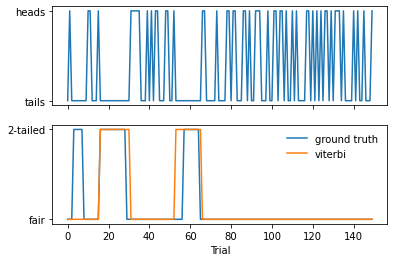

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(viterbi, label='viterbi')
axs[1].set_xlabel('Trial')
axs[1].legend(frameon=False);

The Viterbi algorithm correctly infers a switch to the double-tailed coin in only two of the three cases. The boundaries are also a little generous since coincidentally the fair coin also came up tails on those tosses. It likely missed the other time the double-tailed coin was used because the number of consecutive tails wasn't *quite* long enough to overcome the relatively unlikely event of switching coins. This illustrates one of the weaknesses of the Viterbi algorithm. Since it's forced to choose the states that maximize the probability of observing the emissions, it often doesn't reflect more subtle features of the data.

#### 2.1.5 State inference (forward-backward algorithm)

The forward-backward algorithm yields a more nuanced picture by returning a distribution over states for each time step, a process sometimes called posterior decoding. This is again best illustrated by example, so let's take a look. Like with the forward algorithm, the result is a dictionary of lists of the forward-backward variables at each step keyed by their state label.

In [11]:
fbs = coin.forward_backward(emits)
print(fbs['fair'][:5])
print(fbs['2-tailed'][:5])

[0.9969173859432354, 0.9999999999999453, 0.7282292541700108, 0.5772109744874365, 0.49760039294030484]
[0.0030826140567199616, 0.0, 0.27177074582994637, 0.42278902551251357, 0.5023996070596556]


The probabilities at each step do not sum exactly to one, which is a result of small errors inherent in floating point operations. Though the values are easily re-scaled, this is not done automatically as to not give the user false confidence in the numerical precision of the results.

Let's again plot the results against the emissions and actual states. (We only need to plot the double-tailed forward-backward variables since the fair variables are their complements.)

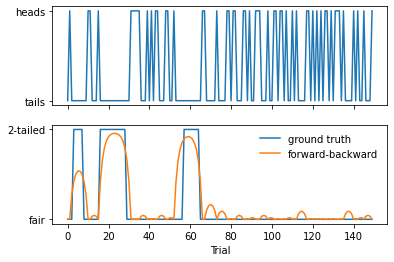

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(fbs['2-tailed'], label='forward-backward')
axs[1].set_xlabel('Trial')
axs[1].legend(frameon=False);

This time the result is much smoother interpolation between states. In particular, there are three peaks which correspond to the three times the dealer used the double-tailed coin. However, there are also many smaller peaks which correspond to other runs of tails of varying lengths. One of the downsides of the forward-backward algorithm is we haven't actually made any state assignments yet. While the smooth posterior decoding curves are visually and theoretically pleasing since they reflect the uncertainty in the state labels, we do at some point have to make a decision and give up this more nuanced picture.

The naive approach is to simply set a cutoff and label any time steps above this value as double-tailed. Unfortunately, unless the cutoff is set very low, this will exclude the "shoulders" of the peaks where the posterior decoding curves return to zero. However, if the cutoff is set too low, we will spuriously label some very short runs of tails as belonging to the double-tailed coin.

The exact shape of the posterior decoding curves is specific to this example as posterior probability of the double-tailed coin must equal zero if a heads was observed. However, the general behavior is characteristic of posterior decoding curves since they smoothly interpolate between states, particularly if the differences between emission distributions are subtle. The issue is that time steps with lower probability for a state of interest are sometimes associated with higher confidence intervals, so we want some way of labeling them together. My usual approach is to set a high and low cutoff. The high cutoff identifies a "seed" for each interval, which is then expanded outwards until the posterior probability is below the low cutoff.

The method of state assignment will depend on the architecture of the HMM and the application. In this example, there are only two states, and goal is to identify the steps belong to the "aberrant" state as completely as possible. However, in other cases, particularly if there are more than two states, the opposition between classes is not nearly as stark, and it's common to use the maximum a posteriori estimate. In yet other cases, I've used a combination of the posterior decoding curves, their derivatives, and the raw data to pinpoint the exact time step where the distribution changes.

#### 2.1.6 Comparing the Viterbi and forward-backward algorithms

The preceding examples and discussion should illustrate that both the Viterbi and forward-backward algorithms have their strengths and weaknesses. To briefly summarize them, the Viterbi algorithm immediately provides a state labeling without any additional steps. However, sometimes the goal is to minimize the cost of rare but expensive events, *e.g.* credit card fraud, rather than to maximize accuracy. Thus, the inability to fine-tune its output is one downside of this method. In contrast, the forward-backward algorithm provides a more nuanced picture by returning a posterior distribution across states at each time step. Translating these distributions into coherent state labelings, though, is sometimes complex and involves many arbitrary decisions.

There's another, more subtle caveat to the forward-backward algorithm as well. The posterior distributions are marginal for each time step rather than joint. In other words, the distribution for a state at one step is not constrained by the state distribution at another. Thus, taking the maximum a posteriori state estimate for each step will not necessarily yield a valid sequence of states if some transitions are not allowed. Thus, the forward-backward algorithm is not always appropriate for applications where a valid state path is necessary to interpret the results.

### 2.2 The occasionally devastating drought

As you may know, the American West is currently in a drought of geologic proportions, with one [study](https://www.nature.com/articles/s41558-022-01290-z) estimating it as the most severe in over 1,200 years. Usually annual rainfall measurements follow consistent distributions, but it appears in recent years the climate has transitioned to a long-standing pattern of reduced rainfall. As grim as this is, it provides some motivation for our next example, which will model continuous measurements using SciPy random variables.

#### 2.2.1 Random variable style instantiation

The climate is a highly complex system that's influenced by many factors, including the increasing concentration of atmospheric CO<sub>2</sub>, but let's say for sake of example we can model it as two-state system, "drought" and "not drought," with annual rainfall as the observed variable. The major difference in this example is the emissions take on continuous values, so we'll use SciPy random variables to specify the emission distributions. As before, I'll instantiate the model and note the key points afterwards.

In [13]:
gamma_ND = stats.gamma(a=10, scale=0.5)
gamma_D = stats.gamma(a=3)
weather = homomorph.HMM(t_dists={'not drought': {'not drought': 0.998, 'drought': 0.002},
                        'drought': {'not drought': 0.05, 'drought': 0.95}},
                        e_dists={'not drought': gamma_ND, 'drought': gamma_D},
                        start_dist={'not drought': 0.99, 'drought': 0.01},
                        name='weather')
weather

HMM(states={'not drought', 'drought'},
    stop_states=[],
    name='weather')

`t_dists` and `start_dist` are identical in form since they are always categorical distributions. Here, however, `e_dists` is a simple dictionary where SciPy random variables are keyed by state labels. (The inner dictionary is now unnecessary as the random variables take care of assigning probabilities to outputs.) In particular, they're gamma random variables, as gamma distributions are commonly used to model continuous, non-negative values. Notice in this case we're using "frozen" random variables, meaning we've called the SciPy random variable with a set of parameters. This generates a new random variable that "remembers" those parameters, so we don't have to provide them every time we call a method. Using frozen random variables is essential for correctly instantiating a model. Otherwise the random variable uses the default parameter values, which is usually not what's intended.

Let's quickly demonstrate this property of frozen random variables by plotting their pdfs.

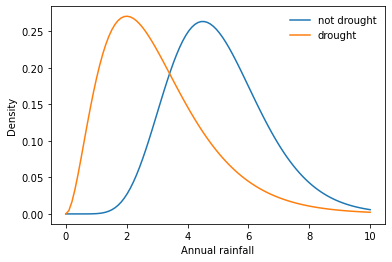

In [14]:
xs = np.linspace(0, 10, 100)
ys_ND = gamma_ND.pdf(xs)
ys_D = gamma_D.pdf(xs)

plt.plot(xs, ys_ND, label='not drought')
plt.plot(xs, ys_D, label='drought')
plt.xlabel('Annual rainfall')
plt.ylabel('Density')
plt.legend(frameon=False);

#### 2.2.2 Simulation

With that out of the way, let's simulate another sequence of states and emissions.

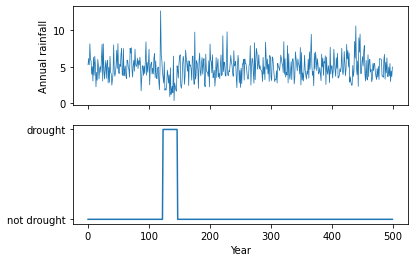

In [15]:
step_num = 500

steps = weather.simulate(step_num, random_state=31)
states = [step[0] for step in steps]
emits = [step[1] for step in steps]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits, linewidth=0.75)
axs[1].plot(states)
axs[1].set_xlabel('Year')
axs[0].set_ylabel('Annual rainfall');

#### 2.2.3 State inference (forward-backward algorithm)

Let's wrap this example up by now inferring the posterior state distributions with the forward-backward algorithm.

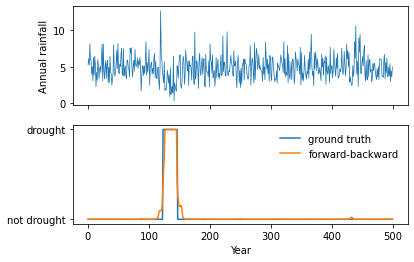

In [16]:
fbs = weather.forward_backward(emits)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits, linewidth=0.75)
axs[1].plot(states, label='ground truth')
axs[1].plot(fbs['drought'], label='forward-backward')
axs[1].set_xlabel('Year')
axs[0].set_ylabel('Annual rainfall')
axs[1].legend(frameon=False);

#### 2.2.4 Comments on random variable style instantiation

Currently, mixing the dictionary and random variable styles is disallowed to simplify handling the arguments. Besides, it would be an extremely rare use case since it implies the existence of states with very different kinds of emissions (a fixed set of choices vs discrete or continuous values). If this is not the case, please don't hesitate to reach out!

Although this example involves continuous emissions, the random variable style is also useful or even necessary for certain kinds of discrete emissions. For example, some types of count measurements, like the number of patrons at a restaurant per day, are not theoretically capped at a maximum value (even if practical concerns dictate otherwise). Since it's impossible to manually specify a probability for each non-negative integer, parametrizing the model with a properly defined distribution, *e.g.* Poisson or negative binomial, is the more appropriate solution.

## 3 Conclusion

We've only scratched the surface of the theory and applications of HMMs, but hopefully this tutorial has provided a strong foundation that will allow you dive into explanations of the underlying algorithms and more complex examples with confidence! Please don't hesitate to reach out if you have any questions.